<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_05_pytorch_sklearn_pipeline_01_threshold_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Threshold Tuning: Brief Description

**Threshold tuning** is the process of adjusting the decision threshold used to classify instances in a binary classification problem. By default, many classifiers use a threshold of 0.5, meaning that if the predicted probability of an instance belonging to the positive class is greater than or equal to 0.5, it is classified as positive; otherwise, it is classified as negative. However, this default threshold may not always be optimal for your specific problem, especially in cases of imbalanced classes or when the costs of false positives and false negatives are different.

### Importance of Threshold Tuning

1. **Class Imbalance**: In many real-world datasets, the classes are imbalanced (one class is much more frequent than the other). Using a default threshold of 0.5 may lead to poor performance on the minority class. Tuning the threshold can help improve the classifier's ability to correctly identify minority class instances.

2. **Cost Sensitivity**: Different applications may have different costs associated with false positives and false negatives. For example, in medical diagnostics, a false negative (failing to identify a disease) might be more costly than a false positive. Adjusting the threshold can help balance the trade-offs between precision and recall to align with the specific cost considerations of your application.

3. **Performance Metrics**: By tuning the threshold, you can optimize the classifier for specific performance metrics that are important for your application, such as maximizing the F1 score, precision, recall, or a combination of these metrics.

### How Threshold Tuning Works

1. **Prediction Probabilities**: The classifier outputs probabilities indicating the likelihood that each instance belongs to the positive class.

2. **Precision-Recall Curve**: You can calculate precision and recall for different thresholds and plot these values to visualize the trade-offs.

3. **Optimal Threshold Selection**: By evaluating performance metrics (such as the F1 score) for different thresholds, you can identify the threshold that provides the best balance between precision and recall, or that maximizes a specific metric.

4. **Applying the Threshold**: Once the optimal threshold is determined, you use it to make final classification decisions, improving the classifier's performance according to your specific criteria.



### Baseline Model Pipeline with Sklearn Wrapper


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define the sklearn wrapper for the neural network model
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight  # Accept as float
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        # Convert pos_weight to tensor here
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.65).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnSimplexNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Function to adjust decision threshold
def predict_with_threshold(model, X, threshold=0.65):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > threshold).float()
    return predictions.numpy().squeeze()

# Predict on the test set with the manually set threshold
test_predictions_best_threshold = predict_with_threshold(nn_estimator.model, X_test_tensor.numpy(), threshold=0.65)

# Evaluate the model with the manually set threshold
print(classification_report(y_test_tensor.numpy(), test_predictions_best_threshold))

              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79      4673
         1.0       0.40      0.68      0.50      1327

    accuracy                           0.70      6000
   macro avg       0.64      0.69      0.64      6000
weighted avg       0.78      0.70      0.72      6000



### Classification Report Analysis

1. **Precision for Class 0 (Non-default)**:
   - **Precision**: 0.89. This means that 89% of the instances predicted as non-defaults were actually non-defaults.
   - **Recall**: 0.71. This indicates that 71% of actual non-defaults were correctly identified by the model.
   - **F1-Score**: 0.79. The harmonic mean of precision and recall for non-defaults.

2. **Precision for Class 1 (Default)**:
   - **Precision**: 0.40. This means that 40% of the instances predicted as defaults were actually defaults. This suggests a relatively high false positive rate.
   - **Recall**: 0.68. This indicates that 68% of actual defaults were correctly identified by the model.
   - **F1-Score**: 0.50. The harmonic mean of precision and recall for defaults.

3. **Overall Metrics**:
   - **Accuracy**: 0.70. This means that 70% of all instances were correctly classified.
   - **Macro Average**:
     - **Precision**: 0.64. The average precision considering both classes equally.
     - **Recall**: 0.69. The average recall considering both classes equally.
     - **F1-Score**: 0.64. The average F1 score considering both classes equally.
   - **Weighted Average**:
     - **Precision**: 0.78. The average precision weighted by the number of instances in each class.
     - **Recall**: 0.70. The average recall weighted by the number of instances in each class.
     - **F1-Score**: 0.72. The average F1 score weighted by the number of instances in each class.

### Observations

- The model has a relatively high precision for non-defaults but a lower precision for defaults, indicating that it predicts non-defaults more accurately than defaults.
- The recall for defaults is moderate, suggesting that the model is able to identify a fair number of defaults but still misses some.
- Overall accuracy is 70%, which is decent, but the disparity in precision and recall for the two classes indicates room for improvement, especially in correctly predicting defaults.

### Recommendations for Next Steps

1. **Threshold Tuning**:
   - Experiment with different decision thresholds to find the optimal balance between precision and recall for the default class.

2. **Further Feature Engineering**:
   - Create new features or transform existing ones to provide more informative inputs to the model. For instance, consider feature interactions, polynomial features, or domain-specific features.

3. **Model Complexity**:
   - Experiment with slightly more complex neural network architectures. Adding more layers or neurons might capture more complex patterns in the data.

4. **Alternative Resampling Techniques**:
   - Try other resampling techniques such as ADASYN or a combination of SMOTE and Tomek links to see if they improve the balance between precision and recall for the default class.

5. **Cost-Sensitive Learning**:
   - Modify the loss function to penalize misclassifications of the default class more heavily. This can be done by adjusting the class weights in the loss function.

6. **Ensemble Methods**:
   - Combine the neural network with other models (e.g., Random Forest, Gradient Boosting) to create an ensemble model that may improve overall performance.

7. **Cross-Validation**:
   - Use cross-validation to ensure the model's robustness and to better tune the hyperparameters.

8. **Regularization**:
   - Apply regularization techniques like L2 regularization (weight decay) or dropout to prevent overfitting and improve generalization.





### Threshold Tuning Plot

You can use a precision-recall curve to find the optimal threshold

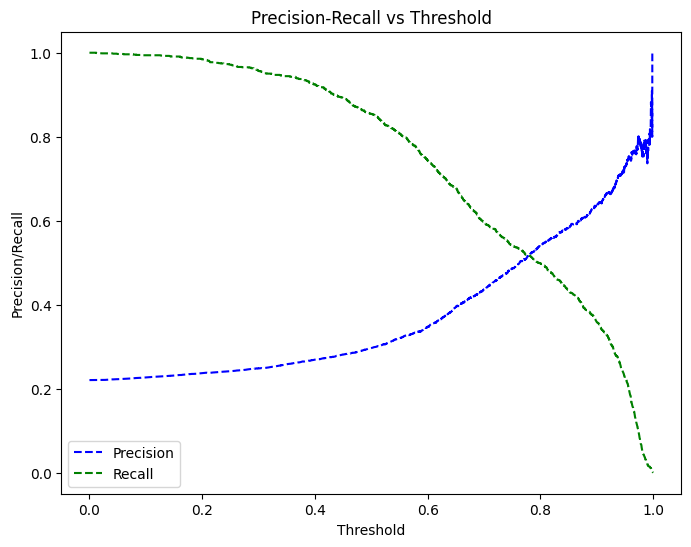

In [2]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Function to plot precision-recall curve
def plot_precision_recall(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.legend(loc='best')
    plt.title('Precision-Recall vs Threshold')
    plt.show()

# Get the predicted probabilities
nn_estimator.model.eval()
with torch.no_grad():
    outputs = nn_estimator.model(X_test_tensor)
    probabilities = torch.sigmoid(outputs).numpy().squeeze()

# Plot precision-recall curve
plot_precision_recall(y_test_tensor.numpy(), probabilities)

### Extracting the Optimal Threshold

Here’s how you can extract the optimal threshold and use it in your model.
This process will help you find and apply the optimal threshold, potentially improving the model’s balance between precision and recall.

In [3]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test_tensor.numpy(), probabilities)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes the F1 score
optimal_threshold_index = f1_scores.argmax()
optimal_threshold = thresholds[optimal_threshold_index]
print(f'Optimal Threshold: {optimal_threshold}')

# Function to predict with the optimal threshold
def predict_with_optimal_threshold(model, X, threshold):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X, dtype=torch.float32))
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > threshold).float()
    return predictions.numpy().squeeze()

# Predict on the test set with the optimal threshold
test_predictions_optimal_threshold = predict_with_optimal_threshold(nn_estimator.model, X_test_tensor.numpy(), optimal_threshold)

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), test_predictions_optimal_threshold))

Optimal Threshold: 0.8000141978263855
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87      4673
         1.0       0.54      0.50      0.52      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.69      0.70      6000
weighted avg       0.79      0.80      0.79      6000



### New Classification Report Analysis

1. **Class 0 (Non-default)**:
   - **Precision**: 0.86. This means that 86% of the instances predicted as non-defaults were actually non-defaults.
   - **Recall**: 0.88. This indicates that 88% of actual non-defaults were correctly identified by the model.
   - **F1-Score**: 0.87. The harmonic mean of precision and recall for non-defaults.

2. **Class 1 (Default)**:
   - **Precision**: 0.54. This means that 54% of the instances predicted as defaults were actually defaults. This suggests an improved precision compared to the original.
   - **Recall**: 0.50. This indicates that 50% of actual defaults were correctly identified by the model. Recall has decreased slightly.
   - **F1-Score**: 0.52. The harmonic mean of precision and recall for defaults.

3. **Overall Metrics**:
   - **Accuracy**: 0.80. This means that 80% of all instances were correctly classified.
   - **Macro Average**:
     - **Precision**: 0.70. The average precision considering both classes equally.
     - **Recall**: 0.69. The average recall considering both classes equally.
     - **F1-Score**: 0.70. The average F1 score considering both classes equally.
   - **Weighted Average**:
     - **Precision**: 0.79. The average precision weighted by the number of instances in each class.
     - **Recall**: 0.80. The average recall weighted by the number of instances in each class.
     - **F1-Score**: 0.79. The average F1 score weighted by the number of instances in each class.


### Key Improvements and Trade-offs

1. **Accuracy**: Increased from 70% to 80%, indicating that the overall correct classification rate has improved.

2. **Precision for Class 1 (Default)**: Increased from 0.40 to 0.54, suggesting that the model now makes more accurate positive predictions, reducing the false positive rate.

3. **Recall for Class 1**: Decreased slightly from 0.68 to 0.50, meaning the model now misses more actual defaults.

4. **F1-Score for Class 1**: Improved marginally from 0.50 to 0.52, showing a slight overall improvement in the balance between precision and recall for defaults.

5. **Class 0 Metrics**: Precision for class 0 decreased slightly from 0.89 to 0.86, but recall increased significantly from 0.71 to 0.88, leading to a higher F1-score for class 0 (from 0.79 to 0.87).

6. **Macro and Weighted Averages**: Both macro and weighted averages for precision, recall, and F1-score have improved, indicating a better overall performance across both classes.

### Summary and Next Steps

- The new model with the optimal threshold has significantly improved accuracy and balanced precision and recall for the two classes better than the original model.
- The higher precision for the default class means fewer false positives, which is beneficial if the cost of false positives is high.
- However, the recall for the default class has decreased, indicating the model misses more actual defaults. This trade-off needs to be considered based on the application context.

### Next Steps

1. **Further Threshold Tuning**: Consider finer adjustments around the current optimal threshold to see if a slightly different threshold could provide better balance between precision and recall for class 1.
2. **Feature Engineering**: Enhance the feature set by exploring interaction terms, polynomial features, or domain-specific features to improve the model's ability to distinguish between classes.
3. **Model Complexity**: Slightly increase the model complexity by adding more layers or neurons, ensuring to monitor for overfitting.
4. **Regularization**: Apply regularization techniques like dropout or weight decay to help the model generalize better.
5. **Ensemble Methods**: Explore ensemble methods to combine the strengths of multiple models, potentially leading to better performance.
6. **Cross-Validation**: Use cross-validation to ensure robustness and stability of the model across different subsets of the data.

By taking these steps, you can continue to refine and improve the model's performance.